#1. Install dependencies

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install yfinance statsmodels scikit-learn tensorflow matplotlib

#2. Imports & Config

In [65]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

import math
import joblib
import os

plt.style.use("default")


# CONFIG
TICKER = "AAPL"            # change to RELIANCE.NS, TCS.NS etc.
START_DATE = "2015-01-01"
END_DATE = "2025-12-03"

LSTM_WINDOW = 60           # past days used as input
FORECAST_HORIZON = 7       # days ahead to predict (7 or 30)
TEST_SIZE_RATIO = 0.2

EPOCHS = 25
BATCH_SIZE = 32

MODEL_DIR = "saved_advanced_model"
os.makedirs(MODEL_DIR, exist_ok=True)


#3. Download Data & Inspect

/tmp/ipython-input-2326448607.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


Data shape after indicators: (2697, 13)
Price            Open       High        Low      Close     Volume     SMA_20  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL              
Date                                                                           
2015-03-16  27.571548  27.809694  27.346757  27.809694  143497200  28.424203   
2015-03-17  28.021133  28.337177  27.965491  28.274858  204092400  28.415411   
2015-03-18  28.265959  28.746704  28.125742  28.593132  261083600  28.412629   
2015-03-19  28.655451  28.766735  28.354987  28.377243  183238000  28.402057   
2015-03-20  28.544168  28.577552  27.856438  28.021137  274780400  28.361995   

Price          SMA_50     EMA_20     RSI_14      MACD    BB_High     BB_Low  \
Ticker                                                                        
Date                                                                          
2015-03-16  26.586999  27.905682  32.710795  0.215746  29.656771  27.191635   
201

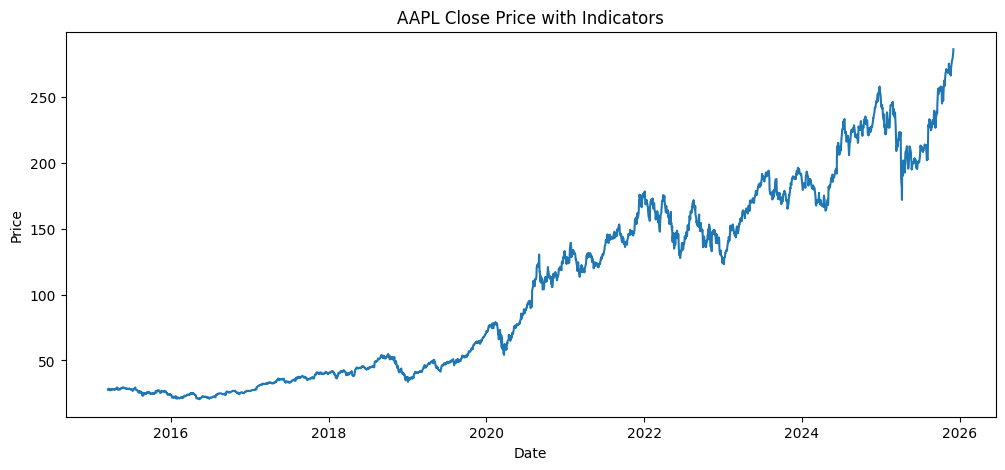

In [66]:
df = yf.download(TICKER, start=START_DATE, end=END_DATE)

# Basic OHLCV
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

close = df['Close'].astype(float)

# Technical Indicators (manual, 1D only)

# Simple Moving Averages
df['SMA_20'] = close.rolling(window=20).mean()
df['SMA_50'] = close.rolling(window=50).mean()

# Exponential Moving Average
df['EMA_20'] = close.ewm(span=20, adjust=False).mean()

# RSI (14-period)
delta = close.diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

window = 14
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
df['RSI_14'] = rsi

# MACD (12, 26)
ema_12 = close.ewm(span=12, adjust=False).mean()
ema_26 = close.ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26

# Bollinger Bands (20, 2)
roll_mean = close.rolling(window=20).mean()
roll_std = close.rolling(window=20).std()
df['BB_High'] = roll_mean + 2 * roll_std
df['BB_Low'] = roll_mean - 2 * roll_std

# Returns
df['Returns'] = close.pct_change()

# Drop NaNs created by indicators
df = df.dropna()

print("Data shape after indicators:", df.shape)
print(df.head())
print("Columns:", df.columns.tolist())

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'])
plt.title(f"{TICKER} Close Price with Indicators")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


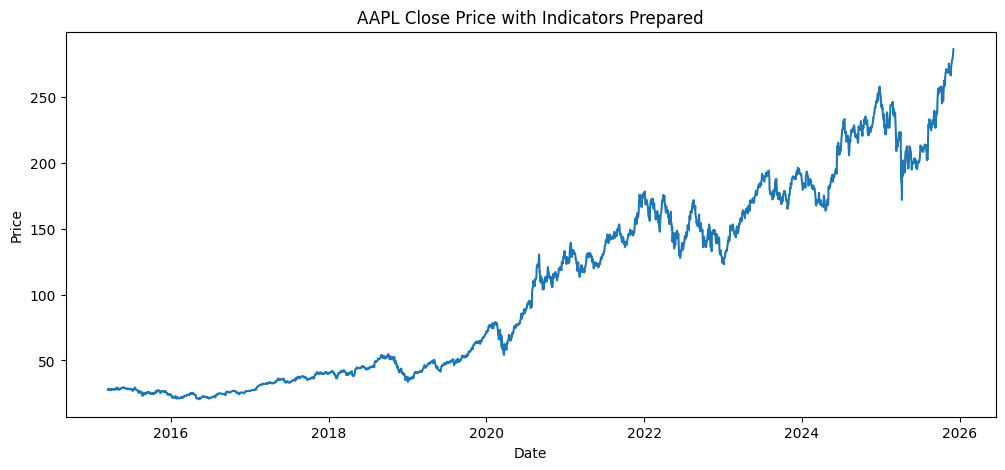

In [67]:
# Ploting
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Close'])
plt.title(f"{TICKER} Close Price with Indicators Prepared")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


#4. Features & Target

In [68]:
feature_cols = df.columns.tolist()   # all as features
target_col = 'Close'                 # what we predict

X_raw = df[feature_cols].values      # (N, n_features)
y_raw = df[[target_col]].values      # (N, 1)

print("X_raw shape:", X_raw.shape)
print("y_raw shape:", y_raw.shape)

n_samples = X_raw.shape[0]
n_features = X_raw.shape[1]

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# Create sequences:
# last LSTM_WINDOW days -> next FORECAST_HORIZON days (Close)
X_seq = []
y_seq = []

for i in range(LSTM_WINDOW, n_samples - FORECAST_HORIZON + 1):
    X_seq.append(X_scaled[i-LSTM_WINDOW:i, :])          # (window, features)
    y_seq.append(y_scaled[i:i+FORECAST_HORIZON, 0])     # (horizon, )

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("X_seq shape:", X_seq.shape)  # (samples, window, n_features)
print("y_seq shape:", y_seq.shape)  # (samples, horizon)


X_raw shape: (2697, 13)
y_raw shape: (2697, 1)
X_seq shape: (2631, 60, 13)
y_seq shape: (2631, 7)


#5. Train and Test Split

In [69]:
train_size = int(len(X_seq) * (1 - TEST_SIZE_RATIO))

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Train samples: 2104
Test samples: 527


#6. Model define and compile

In [70]:
# Bidirectional LSTM Model
model = Sequential([
    Bidirectional(
        LSTM(64, return_sequences=True),
        input_shape=(LSTM_WINDOW, n_features)
    ),
    Bidirectional(
        LSTM(64)
    ),
    Dense(64, activation='relu'),
    Dense(FORECAST_HORIZON)  # multi-step forecast
])

model.compile(optimizer="adam", loss="mse")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ (None, 60, 128)        │        39,936 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,463 (576.03 KB)

 Trainable params: 147,463 (576.03 KB)

 Non-trainable params: 0 (0.00 B)

#7. Training and loss plot

Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - loss: 0.0094 - val_loss: 0.0034
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 4.0344e-04 - val_loss: 9.9244e-04
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 4.0518e-04 - val_loss: 0.0024
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 3.0810e-04 - val_loss: 0.0015
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 2.3579e-04 - val_loss: 0.0013
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 2.7514e-04 - val_loss: 0.0012
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 2.9754e-04 - val_loss: 8.5430e-04
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 2.6488e-04 - val_loss: 0.0018
Epoch 9/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 3.5139e-04 - val_loss: 0.0022
Epoch 10/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 2.4481e-04 - val_loss: 7.2908e-04
Epoch 11/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 2.3352e-04 - val_loss: 0.0

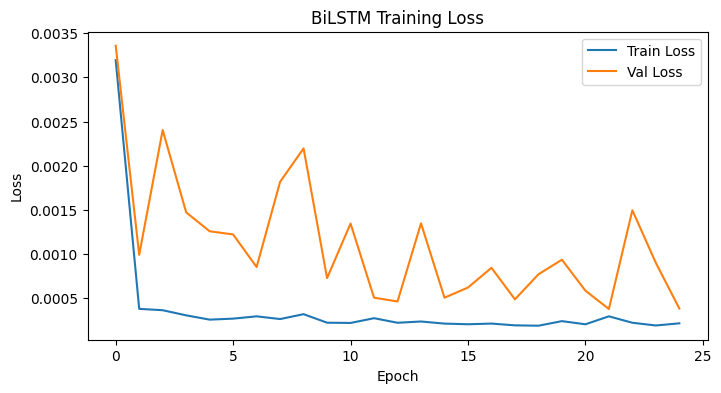

In [71]:
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history.get('val_loss', []), label='Val Loss')
plt.title("BiLSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


#8. Prediction, inverse scaling and RMSE

In [72]:
# Predict on Test Set
y_pred_scaled = model.predict(X_test)  # (samples, horizon)

# Flatten for inverse transform
y_test_flat = y_test.reshape(-1, 1)
y_pred_flat = y_pred_scaled.reshape(-1, 1)

y_test_inv_flat = scaler_y.inverse_transform(y_test_flat)
y_pred_inv_flat = scaler_y.inverse_transform(y_pred_flat)

# Back to (samples, horizon)
y_test_inv = y_test_inv_flat.reshape(y_test.shape[0], y_test.shape[1])
y_pred_inv = y_pred_inv_flat.reshape(y_pred_scaled.shape[0], y_pred_scaled.shape[1])

print("y_test_inv shape:", y_test_inv.shape)
print("y_pred_inv shape:", y_pred_inv.shape)

# Overall RMSE across all steps
rmse_overall = math.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print(f"Overall RMSE (all {FORECAST_HORIZON} steps): {rmse_overall:.4f}")

# RMSE per forecast horizon step
rmse_per_step = []
for step in range(FORECAST_HORIZON):
    rmse_step = math.sqrt(mean_squared_error(y_test_inv[:, step], y_pred_inv[:, step]))
    rmse_per_step.append(rmse_step)

for i, r in enumerate(rmse_per_step, start=1):
    print(f"Day {i} ahead RMSE: {r:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
y_test_inv shape: (527, 7)
y_pred_inv shape: (527, 7)
Overall RMSE (all 7 steps): 15.1813
Day 1 ahead RMSE: 9.4075
Day 2 ahead RMSE: 12.2393
Day 3 ahead RMSE: 12.7406
Day 4 ahead RMSE: 14.0354
Day 5 ahead RMSE: 15.8253
Day 6 ahead RMSE: 19.4941
Day 7 ahead RMSE: 19.6270


#9. Example prediction path

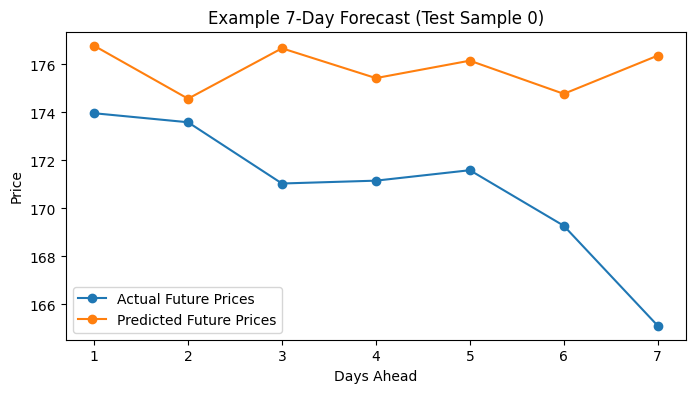

In [73]:
idx = 0  # test sample index
actual_series = y_test_inv[idx]
pred_series = y_pred_inv[idx]

days = list(range(1, FORECAST_HORIZON + 1))

plt.figure(figsize=(8,4))
plt.plot(days, actual_series, marker='o', label="Actual Future Prices")
plt.plot(days, pred_series, marker='o', label="Predicted Future Prices")
plt.title(f"Example {FORECAST_HORIZON}-Day Forecast (Test Sample {idx})")
plt.xlabel("Days Ahead")
plt.ylabel("Price")
plt.legend()
plt.show()


#10. Save artifacts

In [74]:
model_path = os.path.join(MODEL_DIR, "bilstm_multistep.h5")
scaler_X_path = os.path.join(MODEL_DIR, "scaler_X.pkl")
scaler_y_path = os.path.join(MODEL_DIR, "scaler_y.pkl")
meta_path = os.path.join(MODEL_DIR, "meta.npy")

model.save(model_path)
joblib.dump(scaler_X, scaler_X_path)
joblib.dump(scaler_y, scaler_y_path)

# Save meta info: feature names, window, horizon
meta = {
    "feature_cols": feature_cols,
    "target_col": target_col,
    "LSTM_WINDOW": LSTM_WINDOW,
    "FORECAST_HORIZON": FORECAST_HORIZON
}
np.save(meta_path, meta, allow_pickle=True)

print("Saved model & scalers to:", MODEL_DIR)


Saved model & scalers to: saved_advanced_model
